In [1]:
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow_privacy.privacy.optimizers.dp_optimizer import *
import pandas as pd
import seaborn as sns
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import random; random.seed(42)

%load_ext autoreload
%autoreload 2

tf.compat.v1.enable_eager_execution()
assert tf.executing_eagerly

Using TensorFlow backend.


In [2]:
epochs = 1
batch_size = 250

DP-SGD has three privacy-specific hyperparameters and one existing hyperamater that you must tune:

1. `l2_norm_clip` (float) - The maximum Euclidean (L2) norm of each gradient that is applied to update model parameters. This hyperparameter is used to bound the optimizer's sensitivity to individual training points. 
2. `noise_multiplier` (float) - The amount of noise sampled and added to gradients during training. Generally, more noise results in better privacy (often, but not necessarily, at the expense of lower utility).
3.   `microbatches` (int) - Each batch of data is split in smaller units called microbatches. By default, each microbatch should contain a single training example. This allows us to clip gradients on a per-example basis rather than after they have been averaged across the minibatch. This in turn decreases the (negative) effect of clipping on signal found in the gradient and typically maximizes utility. However, computational overhead can be reduced by increasing the size of microbatches to include more than one training examples. The average gradient across these multiple training examples is then clipped. The total number of examples consumed in a batch, i.e., one step of gradient descent, remains the same. The number of microbatches should evenly divide the batch size. 

In [3]:
l2_norm_clip = 0.5
noise_multiplier = 1
num_microbatches = batch_size

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [4]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255
train_data = np.expand_dims(train_data, len(train_data.shape))
test_data = np.expand_dims(test_data, len(test_data.shape))

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

In [5]:
from sklearn.model_selection import train_test_split

# test_size refers to private data size
public_data, private_data, public_labels, private_labels = \
    train_test_split(train_data, train_labels, test_size=239/240)

train_dataset = tf.data.Dataset.from_tensor_slices((private_data, private_labels))
# Data is already shuffled
train_dataset = train_dataset.batch(batch_size)
num_batches = private_data.shape[0] // batch_size

In [6]:
print(public_data.shape)
print(public_labels.shape)
print(private_data.shape)
print(private_labels.shape)

(250, 28, 28, 1)
(250, 10)
(59750, 28, 28, 1)
(59750, 10)


In [7]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    n=private_labels.shape[0], batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=1e-5)

DP-SGD with sampling rate = 0.418% and noise_multiplier = 1 iterated over 239 steps satisfies differential privacy with eps = 1.32 and delta = 1e-05.
The optimal RDP order is 10.0.


(1.3214478128710707, 10.0)

In [8]:
# CNN model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def cnn_model():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=train_data.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.load_weights('mnist_initial_weights.h5')
    
    return model

In [9]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [10]:
def l2_norm(arr):
    return np.sqrt(np.sum(np.square(arr)))

def get_public_grads_layer_norms(public_x, public_y, loss_fn, model):
    public_grads = []
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    for x, y in zip(public_x, public_y):
#     for x, y in tqdm(zip(public_x, public_y), total=public_x.shape[0], desc='Public Dataset Iter'):
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
            grad = tape.gradient(loss_value, model.trainable_weights)
        grad_norms = [l2_norm(t.numpy()) for t in grad]
        public_grads.append(grad_norms)
    # Index is (Layer, Example)
    return np.swapaxes(np.asarray(public_grads), 0, 1)

def get_layer_norms_percentile(layer_norms, percentile):
    layer_percentiles = []
    for layer in layer_norms:
        layer_percentile = np.percentile(np.asarray(layer), norm_percentile, axis=0)
        layer_percentiles.append(layer_percentile)
    return layer_percentiles

def get_total_norm(x, y, loss_fn, model):
    if x.shape[0] != 1:
        x = np.expand_dims(x, axis=0)
    with tf.GradientTape() as tape:
        loss_value = loss_fn(y, model(x))
        grad = tape.gradient(loss_value, model.trainable_weights)
    return np.sqrt(sum([np.sum(np.square(t.numpy())) for t in grad]))

def get_public_total_norms(public_x, public_y, loss_fn, model):
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    return [get_total_norm(x, y, loss_fn, model) for x, y in zip(public_x, public_y)]

def get_public_total_norm_percentile(public_total_norms, norm_percentile):
    return np.percentile(public_total_norms, norm_percentile)

def get_public_grads_weights(public_x, public_y, loss_fn, model):
    public_grads = []
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    for x, y in zip(public_x, public_y):
#     for x, y in tqdm(zip(public_x, public_y), total=public_x.shape[0], desc='Public Dataset Iter'):
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
            grad = tape.gradient(loss_value, model.trainable_weights)
        abs_weights = [np.abs(t.numpy()) for t in grad]
        public_grads.append(abs_weights)
    # Index is (Layer, Example)
    return np.swapaxes(np.asarray(public_grads), 0, 1)

def get_weights_percentile(public_weights, percentile):
    layer_percentiles = []
    for layer in public_weights:
        layer_percentile = np.percentile(np.stack(layer), norm_percentile, axis=0)
        layer_percentiles.append(layer_percentile)
    return layer_percentiles

def evaluate_model(model, loss_fn, x, y):
    pred = model(x)
    loss = np.mean(loss_fn(y, pred).numpy())
    acc = np.mean(tf.keras.metrics.categorical_accuracy(y, pred).numpy())
    return (loss, acc)

In [11]:
model = cnn_model()
optimizer = DPAdamGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [12]:
# Iterate over epochs.
clipped_loss_epochs = []
clipped_acc_epochs = []
norms_batches = []

for epoch in tqdm(range(epochs), desc='Epoch'):
    
    # Evaluate
    loss, acc = evaluate_model(model, loss_fn, private_data, private_labels)
    print("Epoch %d - Loss: %.4f, Acc: %.4f" % (epoch, loss, acc))
    clipped_loss_epochs.append(loss)
    clipped_acc_epochs.append(acc)

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(tqdm(train_dataset, total=num_batches, desc='Batch')):

        public_total_norms = get_public_total_norms(public_data, public_labels, loss_fn, model)
        norms_batches.append(np.median(public_total_norms))
        
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = optimizer.compute_gradients(loss, model.trainable_weights,
                                                              gradient_tape=tape)

        del tape

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(grads)

Epoch 0 - Loss: 2.3028, Acc: 0.0571


Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

In [ ]:
evaluate_model(model, loss_fn, test_data, test_labels)

In [13]:
metrics = pd.DataFrame({
#                         'clipped_loss': clipped_loss_epochs,
#                         'clipped_acc': clipped_acc_epochs,
                        'Public Norm': norms_batches,
                       })
print(metrics)

    Public Norm
0      0.490757
1      0.498973
2      0.504993
3      0.512482
4      0.520691
5      0.529405
6      0.544920
7      0.564867
8      0.585153
9      0.611095
10     0.638045
11     0.670863
12     0.701900
13     0.749463
14     0.797538
15     0.853511
16     0.905675
17     0.958076
18     1.017910
19     1.091786
20     1.151783
21     1.244028
22     1.337149
23     1.432102
24     1.557000
25     1.702052
26     1.844732
27     1.986834
28     2.148806
29     2.290630
30     2.456715
31     2.655486
32     2.850729
33     3.060460
34     3.270918
35     3.478860
36     3.645034
37     3.874516
38     4.135587
39     4.343955
40     4.508960
41     4.663568
42     4.869495
43     5.026430
44     5.169460
45     5.324249
46     5.397785
47     5.481486
48     5.542372
49     5.692319
50     5.616445
51     5.685456
52     5.698852
53     5.552296
54     5.399696
55     5.442460


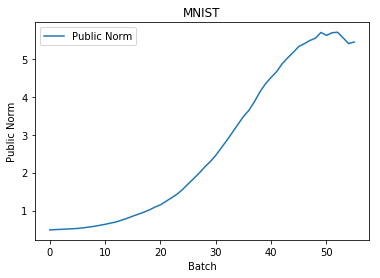

In [15]:
ax = sns.lineplot(data=metrics)
ax.set(xlabel='Batch', ylabel='Public Norm', title='MNIST')
plt.savefig('mnist_norm_over_time.png')